In [7]:
import warnings
warnings.filterwarnings("ignore")

In [1]:
import pandas as pd
import os
import tensorflow as tf
import numpy as np
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D
import matplotlib.pyplot as plt

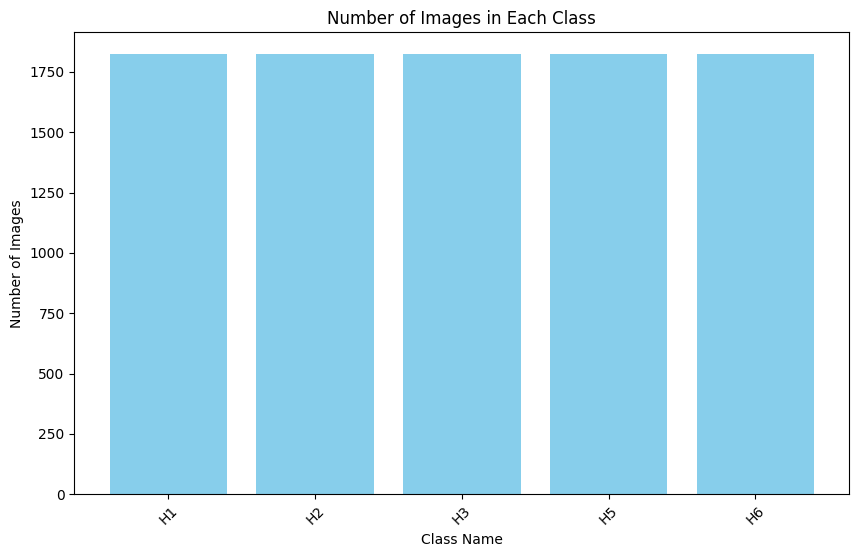

In [8]:
import matplotlib.pyplot as plt

input_folder = "defungi2"

class_names = os.listdir(input_folder)

num_images_per_class = []
for class_name in class_names:
    class_folder = os.path.join(input_folder, class_name)
    num_images = len(os.listdir(class_folder))
    num_images_per_class.append(num_images)

plt.figure(figsize=(10, 6))
plt.bar(class_names, num_images_per_class, color='skyblue')
plt.xlabel('Class Name')
plt.ylabel('Number of Images')
plt.title('Number of Images in Each Class')
plt.xticks(rotation=45)
plt.show()



In [2]:
import os
import shutil
from sklearn.model_selection import train_test_split

input_folder = "defungi"
output_folder = "output"

class_names = os.listdir(input_folder)
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

for class_name in class_names:
    class_folder = os.path.join(input_folder, class_name)
    output_train_folder = os.path.join(output_folder, "train", class_name)
    output_test_folder = os.path.join(output_folder, "test", class_name)
    os.makedirs(output_train_folder, exist_ok=True)
    os.makedirs(output_test_folder, exist_ok=True)

    images = os.listdir(class_folder)
    train_images, test_images = train_test_split(images, test_size=0.2, random_state=42)
    for image in train_images:
        src = os.path.join(class_folder, image)
        dest = os.path.join(output_train_folder, image)
        shutil.copy(src, dest)

    for image in test_images:
        src = os.path.join(class_folder, image)
        dest = os.path.join(output_test_folder, image)
        shutil.copy(src, dest)
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'output/train',
    labels='inferred',
    label_mode='categorical',
    batch_size=256,
    image_size=(256, 256),
    seed=42
)

class_names = train_dataset.class_names
class_names


Found 7290 files belonging to 5 classes.


['H1', 'H2', 'H3', 'H5', 'H6']

In [5]:
image_size = 256

data_generator_with_aug = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    horizontal_flip=True,
    vertical_flip=True,
)

data_generator_no_aug = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = data_generator_with_aug.flow_from_directory(
        'output/train',
        target_size=(image_size, image_size),
        batch_size=256,
        class_mode='categorical',
        shuffle=True)

validation_generator = data_generator_no_aug.flow_from_directory(
        'output/test',
        target_size=(image_size, image_size),
        batch_size=256,
        class_mode='categorical',
        shuffle=True)

Found 7290 images belonging to 5 classes.
Found 1824 images belonging to 5 classes.


In [11]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
import tensorflow as tf

# Load VGG16 model without the fully connected layers
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the convolutional layers
for layer in vgg_base.layers:
    layer.trainable = False

# Adding custom fully connected layers
x = GlobalAveragePooling2D()(vgg_base.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(5, activation='softmax')(x)  # Assuming 5 classes for classification

# Create the model
model = Model(inputs=vgg_base.input, outputs=output)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])




In [12]:
hist = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=60,
    verbose=1
).history

# Print model summary
model.summary()

Epoch 1/60
29/29 [==============================] - 871s 30s/step - loss: 1.3183 - accuracy: 0.5221 - val_loss: 0.8902 - val_accuracy: 0.6612
Epoch 2/60
29/29 [==============================] - 775s 27s/step - loss: 0.9143 - accuracy: 0.6329 - val_loss: 0.7907 - val_accuracy: 0.6908
Epoch 3/60
29/29 [==============================] - 771s 27s/step - loss: 0.8107 - accuracy: 0.6682 - val_loss: 0.7329 - val_accuracy: 0.7198
Epoch 4/60
29/29 [==============================] - 771s 27s/step - loss: 0.7519 - accuracy: 0.6985 - val_loss: 0.6774 - val_accuracy: 0.7467
Epoch 5/60
29/29 [==============================] - 776s 27s/step - loss: 0.7084 - accuracy: 0.7165 - val_loss: 0.6466 - val_accuracy: 0.7489
Epoch 6/60
29/29 [==============================] - 781s 27s/step - loss: 0.6582 - accuracy: 0.7346 - val_loss: 0.6306 - val_accuracy: 0.7604
Epoch 7/60
29/29 [==============================] - 771s 27s/step - loss: 0.6454 - accuracy: 0.7374 - val_loss: 0.6082 - val_accuracy: 0.7719
Epoch 

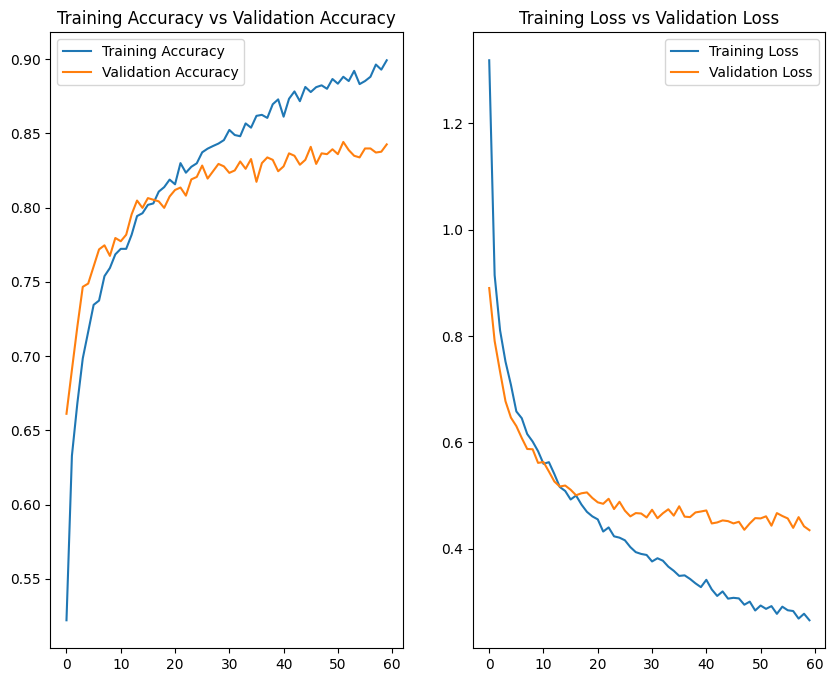

In [17]:
acc=hist['accuracy']
val_acc=hist['val_accuracy']

loss=hist['loss']
val_loss=hist['val_loss']

plt.figure(figsize=(10,8))

plt.subplot(1,2,1)
plt.plot(range(60),acc,label='Training Accuracy')
plt.plot(range(60),val_acc,label='Validation Accuracy')
plt.legend()
plt.title("Training Accuracy vs Validation Accuracy")


plt.subplot(1,2,2)
plt.plot(range(60),loss,label='Training Loss')
plt.plot(range(60),val_loss,label='Validation Loss')
plt.title("Training Loss vs Validation Loss")
plt.legend()
plt.show()

In [16]:
model.save("vgg1.h5")

In [6]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import tensorflow as tf

# Load the saved model
model = tf.keras.models.load_model("vgg1.h5")

# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(validation_generator, verbose=1)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)





8/8 [==============================] - 242s 21s/step - loss: 0.4350 - accuracy: 0.8427
Test Loss: 0.43498146533966064
Test Accuracy: 0.8426535129547119
